# Import packages

In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time

from ssa.models import fit_ssa, weighted_pca, weighted_rrr
from ssa.util import get_sample_weights

In [2]:
# %load_ext autoreload
# %autoreload 2

# Simulate data

In [3]:
#Function that creates a sine wave for a given amount of time (T),
#where the number of cycles (c) occurs during that time
def create_sine(T,c):
    tau=T/(2*np.pi)/c
    return np.sin(np.arange(0,T)/tau)

#### Generate the simulated data X0, which is size [Time x Num_neurons]

In [4]:
np.random.seed(0) #To get the same simulated data

T=1200 #Time
N=50 #Number of neurons
R_sim=7 #Number of dimensions in lowD representations

#Orthogonal matrix that projects low dimensional space to full neural space
V_tmp=orth(npr.randn(R_sim,N).T).T 

#Create low dimensional space
Z=np.zeros([T,R_sim])
for i in range(7):
    Z[150*i:150*i+300,i]=create_sine(300,i+1)

#Create high-dimensional neural activity    
b=npr.randn(N) #Offset of neurons
X0=Z@V_tmp[:R_sim,:]+b #Project into high-dimensional space and add offset
X0=X0+.1*npr.randn(X0.shape[0],X0.shape[1]) #Add noise

# Preprocess data (optional)

I have found that the method usually works better when zero-centering the data.

In this specific example, if you don't zero-center the data, it will take ~10000 iterations to converge to the ground truth, rather than ~2000.

In [5]:
# X =np.copy(X0)
X=np.copy(X0-np.mean(X0,axis=0)[None,:])

# Set required model parameters

In [6]:
#Number of dimensions in the low-D model you're fitting
R_est=8

# Set optional model parameters

All of these have default values, so it's not essential to set them. The values listed below are the default values.

In [7]:
#Strength of the sparsity penalty
lam=.01

#Number of epochs of model fitting
n_epochs=3000

#Learning rate of model fitting
lr=.001

#Whether to print the model error while fitting
verbose=True

In [8]:
#How much to weight each data point in time
#(this can be helpful for making sure dimensions still aim to explain time points with low activity)

sample_weights=np.ones([X.shape[0],1]) #Weight equally

# sample_weights=get_sample_weights(X) #Weight inversely to norm of activity at each time point

# Fit PCA Model (for comparison)

In [9]:
#Fit weighted PCA
#Note that this function does not automatically subtract the mean from the data (as in many PCA functions)
U_est_pca,V_est_pca = weighted_pca(X,R_est,sample_weights)

#Get the low dimensional representation (the principal components)
pca_latent = X@U_est_pca

# Fit SSA Model

In [10]:
#Fit SSA
model, latent, y_pred = fit_ssa(X=X,R=R_est,sample_weight=sample_weights,lam=lam,lr=lr,n_epochs=n_epochs,verbose=verbose)

#Fit SSA without all the optional parameters
# model, latent, y_pred = fit_ssa(X=X,R=R_est)

#Get the low dimensional representation
ssa_latent=latent.detach().numpy()

Training loss before training 517.9017944335938
Epoch 0: train loss: 517.9017944335938
Epoch 10: train loss: 517.6685791015625
Epoch 20: train loss: 517.514404296875
Epoch 30: train loss: 517.3779296875
Epoch 40: train loss: 517.2529907226562
Epoch 50: train loss: 517.1324462890625
Epoch 60: train loss: 517.01416015625
Epoch 70: train loss: 516.89453125
Epoch 80: train loss: 516.7762451171875
Epoch 90: train loss: 516.6549682617188
Epoch 100: train loss: 516.5307006835938
Epoch 110: train loss: 516.4048461914062
Epoch 120: train loss: 516.279296875
Epoch 130: train loss: 516.1505126953125
Epoch 140: train loss: 516.0171508789062
Epoch 150: train loss: 515.8818969726562
Epoch 160: train loss: 515.7451782226562
Epoch 170: train loss: 515.6071166992188
Epoch 180: train loss: 515.4658813476562
Epoch 190: train loss: 515.31982421875
Epoch 200: train loss: 515.1708984375
Epoch 210: train loss: 515.0210571289062
Epoch 220: train loss: 514.8705444335938
Epoch 230: train loss: 514.7213134765625

Epoch 2050: train loss: 512.001220703125
Epoch 2060: train loss: 512.001220703125
Epoch 2070: train loss: 512.0011596679688
Epoch 2080: train loss: 512.0010986328125
Epoch 2090: train loss: 512.0010375976562
Epoch 2100: train loss: 512.0011596679688
Epoch 2110: train loss: 512.0011596679688
Epoch 2120: train loss: 512.0010986328125
Epoch 2130: train loss: 512.0011596679688
Epoch 2140: train loss: 512.0010986328125
Epoch 2150: train loss: 512.001220703125
Epoch 2160: train loss: 512.0011596679688
Epoch 2170: train loss: 512.0010986328125
Epoch 2180: train loss: 512.0011596679688
Epoch 2190: train loss: 512.0011596679688
Epoch 2200: train loss: 512.0011596679688
Epoch 2210: train loss: 512.0011596679688
Epoch 2220: train loss: 512.0011596679688
Epoch 2230: train loss: 512.0010986328125
Epoch 2240: train loss: 512.0011596679688
Epoch 2250: train loss: 512.001220703125
Epoch 2260: train loss: 512.0011596679688
Epoch 2270: train loss: 512.001220703125
Epoch 2280: train loss: 512.00115966796

# Plot results

### Plot unordered lowD representations

Text(0.5, 1.0, 'PCA LowD Projections')

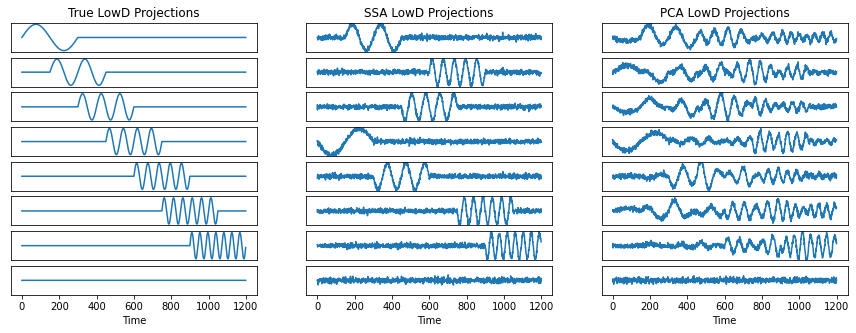

In [11]:
#Ground truth
Z_extra=np.zeros([T,R_est])
Z_extra[:,:R_sim]=Z


plt.figure(figsize=(15,5))
for i in range(R_est):
    
    #Plot ground truth
    plt.subplot(R_est,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SSA results
    plt.subplot(R_est,3,3*i+2)
    plt.plot(ssa_latent[:,i])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,3,3*i+3)
    plt.plot(pca_latent[:,i])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(R_est,3,1)
plt.title('True LowD Projections')

plt.subplot(R_est,3,2)
plt.title('SSA LowD Projections')

plt.subplot(R_est,3,3)
plt.title('PCA LowD Projections')


### Order low-dimensional representations by time of maximum variance explained by that dimension.

In [12]:
#Amount of squared activity each dimension explains in PCA
infs_pca=[np.sum((pca_latent[:,i:i+1]@V_est_pca[i:i+1,:])**2,axis=1) for i in range(R_est)]

#Amount of squared activity each dimension explains in SSA
V_est_ssa=model.fc2.weight.detach().numpy()
infs_ssa=[np.sum((ssa_latent[:,i:i+1]@V_est_ssa[:,i:i+1].T)**2,axis=1) for i in range(R_est)]

#Find the time point of each dimension that has the largest squared activity explained
max_array_pca=[np.argmax(infs_pca[i]) for i in range(R_est)]
max_array_ssa=[np.argmax(infs_ssa[i]) for i in range(R_est)]

#Order dimensions
pca_order=np.argsort(np.array(max_array_pca))
ssa_order=np.argsort(np.array(max_array_ssa))

#### Plot!

Text(0.5, 1.0, 'PCA LowD Projections')

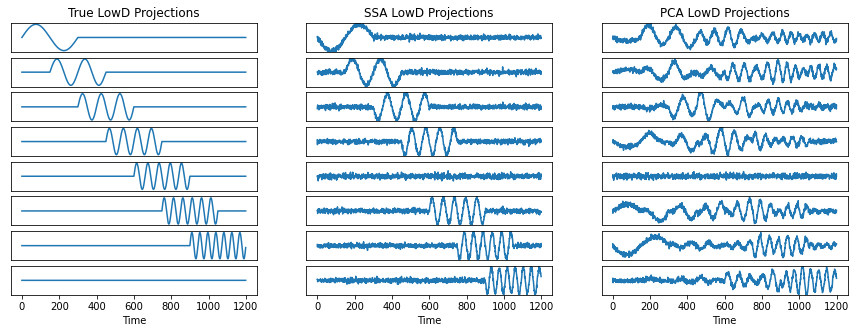

In [13]:
#Ground truth
Z_extra=np.zeros([T,R_est])
Z_extra[:,:R_sim]=Z


plt.figure(figsize=(15,5))
for i in range(R_est):
    
    #Plot ground truth
    plt.subplot(R_est,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SSA results
    plt.subplot(R_est,3,3*i+2)
    plt.plot(ssa_latent[:,ssa_order[i]])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,3,3*i+3)
    plt.plot(pca_latent[:,pca_order[i]])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(R_est,3,1)
plt.title('True LowD Projections')

plt.subplot(R_est,3,2)
plt.title('SSA LowD Projections')

plt.subplot(R_est,3,3)
plt.title('PCA LowD Projections')
